# Permutation importance & calibration

В данном ноутбуке проверяется модель на переобученность и избыточность фичей с помощью permutation importance и uplift.

Далее проверяется калибровка результата модели.

Вход: предобработанные паркеты + обученная модель

Выход: график uplift и калибровки

In [1]:
import setproctitle

setproctitle.setproctitle("alex_permutation")

In [2]:
import gc
import os
import sys
import time

import catboost
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm

tqdm.pandas()

In [4]:
samples = {
    k: pd.read_parquet(f"/home/asciishell/s3/jupyter.asciishell.ru/data_{k}.parquet") for k in ["train", "oos", "oot"]
}

In [9]:
features = [
    "annual_inc",
    "debt_load",
    "emp_title",
    "fico_range_high",
    "funded_amnt_inv",
    "log_annual_inc",
    "num_rev_tl_bal_gt_0",
    "application_type",
    "fraq_annual_inc",
    "disbursement_method",
    "num_bc_tl",
    "annual_inc_joint",
    "desc",
    "initial_list_status",
    "num_op_rev_tl",
    "num_sats",
    "num_rev_accts",
    "num_bc_sats",
    "bc_open_to_buy",
    "earliest_cr_line",
    "num_il_tl",
    "addr_state",
    "emp_length",
    "pct_tl_nvr_dlq",
    "open_acc",
    "mort_acc",
    "inq_fi",
    "fico_range_low",
    "home_ownership",
    "all_util",
]

cat_features = [
    "emp_title",
    "home_ownership",
    "verification_status",
    "purpose",
    "zip_code",
    "addr_state",
    "initial_list_status",
    "application_type",
    "verification_status_joint",
    "disbursement_method",
]
cat_features = sorted(set(cat_features) & set(features))
params = {
    "iterations": 400,
    "depth": 6,
    "l2_leaf_reg": 24.337217538245532,
    "learning_rate": 0.14119449759028455,
    "random_strength": 1.284731588293853,
    "rsm": 0.5363370106196876,
    "grow_policy": "SymmetricTree",
    "od_wait": 50,
    "eval_metric": "AUC",
    "logging_level": "Silent",
}

In [10]:
pools = {
    k: catboost.Pool(v[v["target"] != -1][features], v[v["target"] != -1]["target"], cat_features=cat_features)
    for k, v in samples.items()
}
# pools['train'].quantize()
# pools['train'].save_quantization_borders('borders.dat')
# pools['oos'].quantize(input_borders='borders.dat')
# pools['oot'].quantize(input_borders='borders.dat')

# Train some model

In [11]:
clf = catboost.CatBoostClassifier(**params)
clf.fit(
    pools["train"],
    eval_set=pools["oos"],
    verbose=0,
    plot=True,
)
clf.save_model('catboost.cb')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [15]:
# Перемешивание колонки для uplift
import contextlib


@contextlib.contextmanager
def column_shuffler(df, col, rs):
    orig = df[col].copy()
    df[col] = df[col].sample(frac=1, random_state=rs).values
    try:
        yield df
    finally:
        df[col] = orig

In [16]:
x = samples['oos'][samples['oos']['target'] != -1].copy()
imp = []
for i, f in enumerate(tqdm(features)):
    with column_shuffler(x, f, 42) as dfs:
        proba = clf.predict_proba(dfs[features])[:, 1]
        imp.append({
            'feature': f,
            'imp': roc_auc_score(dfs['target'], proba)
        })
imp = pd.DataFrame(imp).sort_values('imp').reset_index(drop=True)
imp

  0%|          | 0/30 [00:00<?, ?it/s]

,feature,imp
0,funded_amnt_inv,0.596828
1,debt_load,0.635610
2,annual_inc,0.659668
3,log_annual_inc,0.661498
4,emp_title,0.684143
5,fico_range_high,0.685316
6,bc_open_to_buy,0.686750
7,addr_state,0.689304
8,home_ownership,0.689824
9,num_rev_accts,0.691422


In [17]:
uplift = []
for thr in tqdm(
    sorted(
        set(np.percentile(imp["imp"], np.linspace(0, 100, 20), interpolation="midpoint"))
        # | set(np.percentile(imp["imp"], np.linspace(0, 20, 20), interpolation="midpoint"))
        | set([imp["imp"].max()])
    )
):
    features2 = imp[imp["imp"] <= thr]["feature"].values.copy()
    pools2 = {
        k: catboost.Pool(
            v[v["target"] != -1][features2],
            v[v["target"] != -1]["target"],
            cat_features=sorted(set(features2) & set(cat_features)),
        )
        for k, v in samples.items()
    }
    clf = catboost.CatBoostClassifier(**params)
    clf.fit(pools2["train"], eval_set=pools2["oos"], verbose=0, plot=False)

    x = samples["train"][samples["train"]["target"] != -1]
    proba = clf.predict_proba(x[features2])[:, 1]
    mtrain = roc_auc_score(x["target"], proba)

    x = samples["oos"][samples["oos"]["target"] != -1]
    proba = clf.predict_proba(x[features2])[:, 1]
    moos = roc_auc_score(x["target"], proba)

    uplift.append(
        {
            "columns": len(features2),
            "features": features2,
            "train_score": mtrain,
            "test_score": moos,
        }
    )
uplift = pd.DataFrame(uplift)
uplift

  0%|          | 0/20 [00:00<?, ?it/s]

,columns,features,train_score,test_score
0,1,[funded_amnt_inv],0.564480,0.563185
1,2,"[funded_amnt_inv, debt_load]",0.595803,0.592391
2,4,"[funded_amnt_inv, debt_load, annual_inc, log_a...",0.634361,0.626536
3,5,"[funded_amnt_inv, debt_load, annual_inc, log_a...",0.730665,0.638189
4,7,"[funded_amnt_inv, debt_load, annual_inc, log_a...",0.735310,0.668257
5,8,"[funded_amnt_inv, debt_load, annual_inc, log_a...",0.792261,0.672576
6,10,"[funded_amnt_inv, debt_load, annual_inc, log_a...",0.817588,0.677969
7,11,"[funded_amnt_inv, debt_load, annual_inc, log_a...",0.811269,0.679883
8,13,"[funded_amnt_inv, debt_load, annual_inc, log_a...",0.809181,0.687512
9,14,"[funded_amnt_inv, debt_load, annual_inc, log_a...",0.802933,0.687333


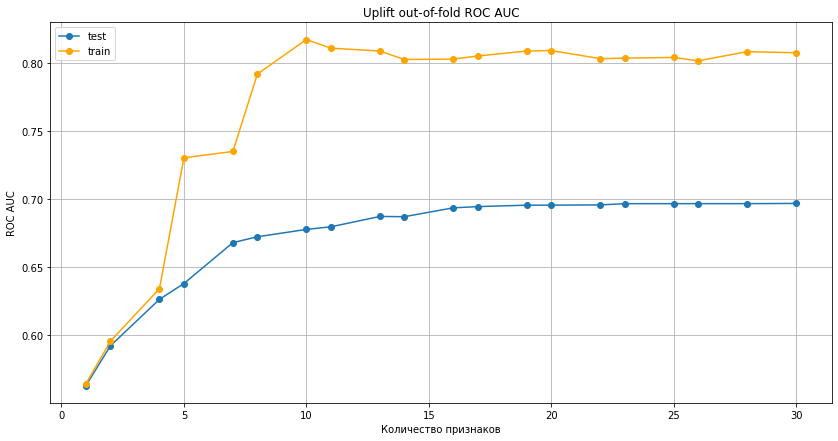

In [18]:
plt.figure(figsize=(14, 7), facecolor='w')
plt.plot(uplift['columns'], uplift['test_score'], marker='o', label='test')
plt.plot(uplift['columns'], uplift['train_score'], marker='o', color='orange', label='train')

plt.title('Uplift out-of-fold ROC AUC')
plt.legend()
plt.xlabel('Количество признаков')
plt.ylabel('ROC AUC')
# plt.twinx()
plt.grid()

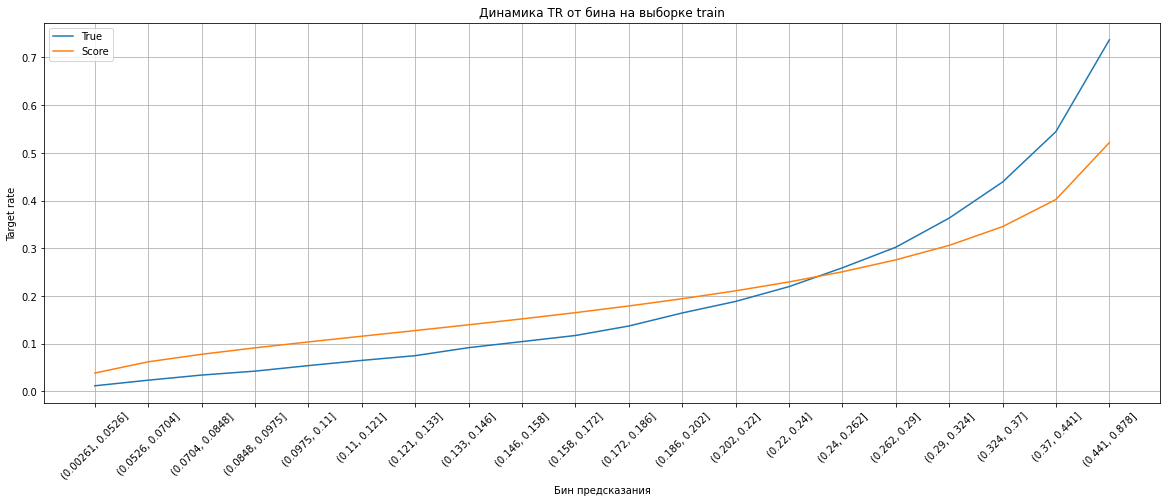

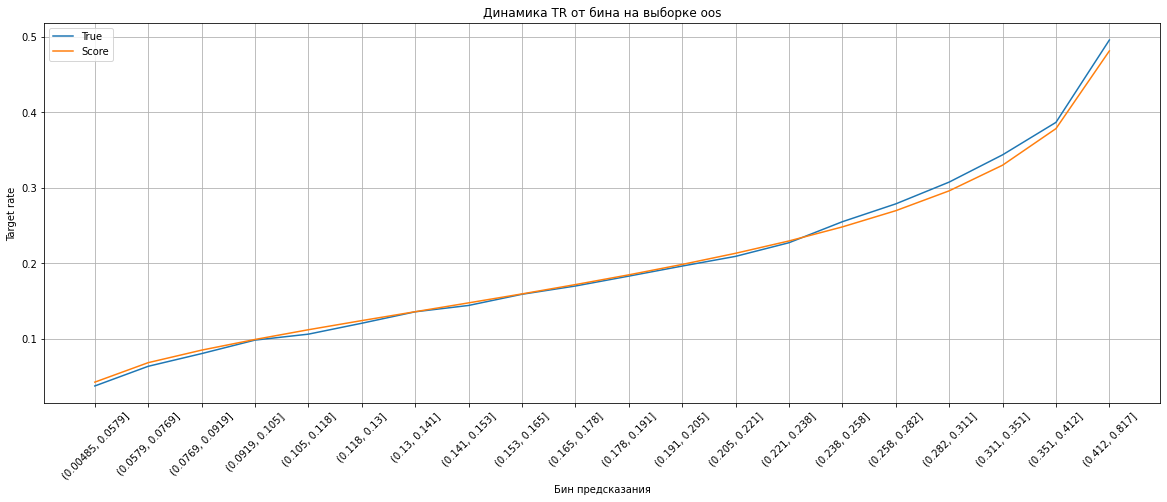

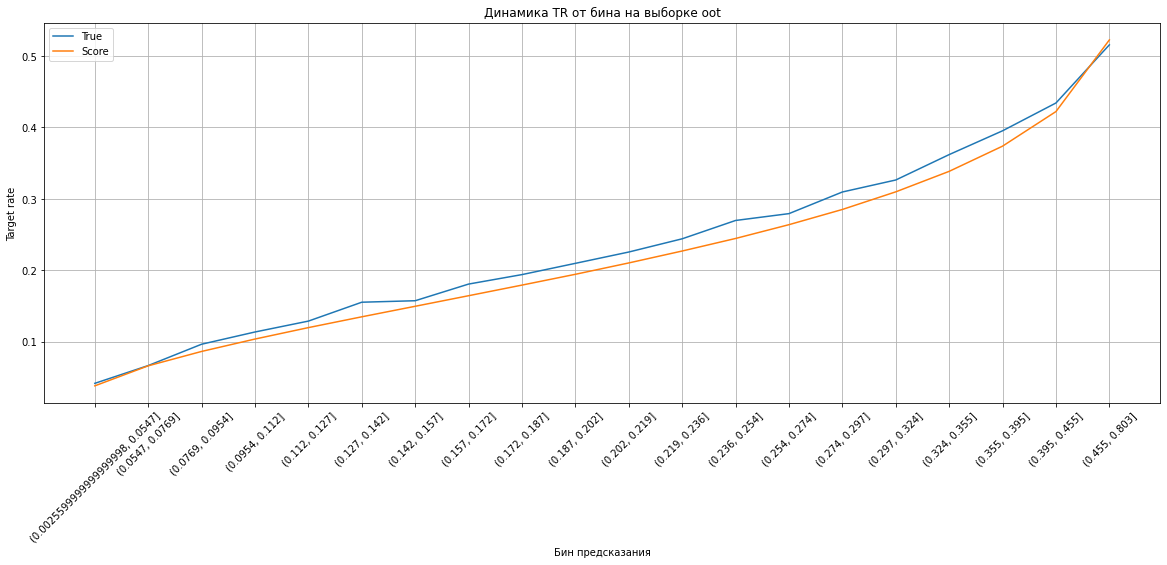

In [19]:
for k, v in samples.items():
    x = v[v["target"] != -1]
    y_true = x['target'].values
    y_score = clf.predict_proba(x[features2])[:, 1]
    data = pd.DataFrame({'true': y_true, 'score': y_score})
    x = data.assign(q=pd.qcut(data['score'], q=20, duplicates='drop')).groupby('q').agg('mean')
    xi = np.arange(len(x))
    plt.figure(figsize=(20, 7), facecolor='w')
    plt.plot(xi, x['true'].values, label='True')
    plt.plot(xi, x['score'].values, label='Score')
    plt.xticks(xi, x.index, rotation=45)

    plt.xlabel('Бин предсказания')
    plt.ylabel('Target rate')
    plt.title(f'Динамика TR от бина на выборке {k}')
    plt.grid()
    plt.legend()
    plt.show()